In [1]:
import torch
import torch.nn as nn
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.manifold import LocallyLinearEmbedding as LLE
from scipy.spatial.distance import pdist
from utils import normalize, Assessment, plot_time_comparison, residual_correlation, split_two
%load_ext autoreload
%autoreload 2

In [9]:
data_LLE = pd.read_csv("data\LLE_semi_set.csv")
data_LLE = data_LLE.groupby(["Number of neighbors","Output dimension"]).mean().reset_index()
data_LLE = data_LLE[data_LLE["Number of neighbors"] == 103]
data_LLE.head()

,Number of neighbors,Output dimension,Reconstruction error,Residual variance,KNN Accuracy,KNN F1 measure,KNN accuracy std,KNN F1 measure std
200,103.0,1.0,5.320666e-08,0.560001,75.375639,0.669624,1.510775,0.016771
201,103.0,2.0,8.417022e-07,0.389327,80.477903,0.741526,0.940842,0.014788
202,103.0,3.0,2.241410e-06,0.292222,88.040400,0.846245,1.209103,0.015727
203,103.0,4.0,6.251703e-06,0.305124,88.178606,0.848254,0.982866,0.012427


# About the dataset 

The data set contains some information about mails (frequency of some words, special characters, number of capital letters etc...). Each mail is then classified as spam (class = 1) or not spam (class = 0). Each datapoint has 56 features, if you want to get more information about these features, you can go in the data folder where all these information are detailed (or you can go directly on the website where the data set is available https://archive.ics.uci.edu/ml/datasets/Spambase). The goal of this project is to find a manifold where the data of interest lies (if it exists one). Here, the data of interest is of course to know if a mail is a spam or not. Let's then try to find a lower-dimensional space where we can easily separate these two classes. 

In [2]:
columns = ["Class"]
columns += ["Frequence word " + str(i) for i in range(1,49)]
columns += ["Special character " + str(i) for i in range(1,7)]
columns += ["Capital length mean"]
columns += ["Capital length longest"]
columns += ["Sum of captital length"]
data = pd.read_csv("../Data/spambasedata.csv",names=columns)
data.shape # Let's have a look at the sructure of the data set
data_np = data.to_numpy().astype(float) # Convert it to a numpy array
data_np = split_two(data_np)

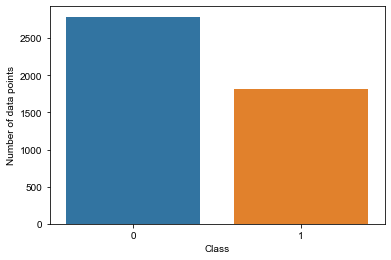

In [4]:
class_dist = data.groupby(["Class"]).count().iloc[:,0].reset_index()
class_dist.rename(columns={"Frequence word 1":"Number of data points"},inplace=True)
sns.barplot(data=class_dist,x="Class",y="Number of data points")
sns.set_style("darkgrid")
plt.show()

# Dimensionality Reduction

We will test and compare two dimensionality reduction methods : Locally Linear Embeddings (LLE) and one of its derivative Modified Locally Linear Embeddings (MLLE). To do so we will see if this these algorithms are able to extract the relevant information, idest to separate the 2 classes in two different clusters. 

### Sanity checks

In [5]:
range_components = np.arange(2,51,4)
range_neighbors = np.arange(10,41,5)
myalgo = Assessment(data_np,range_components,range_neighbors,check=False)

In [6]:
train_set, test_set = myalgo.crossksets(data_np)
print("number of sets",len(train_set))
print("size of one training set",train_set[1].shape)
print("size of one testing set",test_set[1].shape)
print("size of last training set",train_set[-1].shape)
print("size of last testing set",test_set[-1].shape)
print("ratio of classes",train_set[0][train_set[0][:,0] == 1].shape[0]/train_set[0].shape[0]*100)

number of sets 3
size of one training set (1534, 58)
size of one testing set (767, 58)
size of last training set (1535, 58)
size of last testing set (766, 58)
ratio of classes 39.39986953685584


In [7]:
train_set_2, test_set_2 = myalgo.crossksets(data_np)
print("Number of different values :",(train_set[0] != train_set_2[0]).sum())
print("Number of different values :",(train_set[1] != train_set_2[1]).sum())
print("Number of different values :",(test_set[0] != test_set_2[0]).sum())

Number of different values : 29447
Number of different values : 29337
Number of different values : 14503


# Locally Linear Embeddings

In [8]:
range_components = np.arange(1,4,2)
range_neighbors = np.arange(10,101,10)
LLE_algo = Assessment(data_np,range_components,range_neighbors,k=5,check=False,norm=False,norm_0100=True)

### Have a look on the first 4 components

In [10]:
k_cand  = [34,103,200]
for k in k_cand:
    LLE_algo.generate_pairplot(k,4,save_file="LLE_pairplot_semi_set_k="+str(k),title="k="+str(k))

In [ ]:
LLE_algo.generate_3Dplot(10,"LLE")

## Hyperparameters analysis

1 classical metric and two additional ones have been chosen to determine the number of neighbors to use:
* The reconstruction error, or the cumulative sum of the eigenvalues
* The accuracy and the F1 measure using linear SVM to separate the classes
* The accuracy and the F1 measure using KNN to separate the classes

In [ ]:
LLE_algo.reset()
LLE_algo.find_hyper()

In [ ]:
LLE_algo.generate_all(save_file="LLE_test")

In [ ]:
LLE_algo.plot_cumulative_error(title="Reconstruction error",save_file="LLE_cum_test")

In [ ]:
LLE_algo.plot_residual_variance(title="Residual Variance",save_file="LLE_residual_test")

# Modified Locally Linear Embeddings 

In [11]:
range_components = np.arange(2,8,5)
range_neighbors = np.arange(40,101,30)
MLLE_algo = Assessment(data_np,range_components,range_neighbors,k=5,method="modified",check=False,norm=False,norm_0100=True)

### Have a look on the first 4 components

In [12]:
k_cand  = [16,50,200]
for k in k_cand:
    MLLE_algo.generate_pairplot(k,4,save_file="MLLE_pairplot_semi_set_k="+str(k),title="k="+str(k))

In [ ]:
fig = plt.figure(figsize=[10,8])
MLLE_algo.generate_3Dplot(50,fig,[1,1,1],"MLLE")
fig.savefig("test.svg")

## Hyperparameters analysis

1 classical metric and two additional ones have been chosen to determine the number of neighbors to use:
* The reconstruction error, or the cumulative sum of the eigenvalues
* The accuracy and the F1 measure using linear SVM to separate the classes
* The accuracy and the F1 measure using KNN to separate the classes

In [ ]:
MLLE_algo.reset()
MLLE_algo.find_hyper()

In [ ]:
MLLE_algo.generate_all(save_file="not none")

In [ ]:
MLLE_algo.plot_cumulative_error(title="Reconstruction error",save_file="MLLE_cum_test")

In [ ]:
MLLE_algo.plot_residual_variance(title="Residual Variance",save_file="MLLE_residual_test")